<a href="https://colab.research.google.com/github/gitHubAndyLee2020/FinanceBERT/blob/main/financial_bert_monthly_prediction_training_from_embedding_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Market Prediction with FinancialBERT

**Research Goal**: Implement and compare base FinancialBERT model with novel architectures for improved stock market prediction using news headlines.

## Configuration

Set development parameters and training sample limits.

In [1]:
# Import all required libraries
import json
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Core ML libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import faiss

# Transformers
from transformers import BertModel, BertTokenizer

# Additional libraries for future novelties
# Attention mechanisms (built into PyTorch)
# TCN - Will need: pip install torch-tcn (if not already installed)
# GNN - Will need: pip install torch-geometric (if not already installed)

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


c:\Users\ASUS\anaconda3\envs\mltorch311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All libraries imported successfully!
PyTorch version: 2.7.0+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
# DEVELOPMENT CONFIGURATION
# Set to None to train on full dataset
DEVELOPMENT_MODE = False
TRAIN_SAMPLE_LIMIT = 100 if DEVELOPMENT_MODE else None

# Model configuration
BATCH_SIZE = 16
LEARNING_RATE = 1e-5
NUM_EPOCHS = 5 if DEVELOPMENT_MODE else 50
MAX_SEQUENCE_LENGTH = 64
TOP_K_HEADLINES = 5
TEST_SIZE = 0.1
RANDOM_SEED = 42

print(f"Development Mode: {DEVELOPMENT_MODE}")
print(f"Train Sample Limit: {TRAIN_SAMPLE_LIMIT}")
print(f"Number of Epochs: {NUM_EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")

Development Mode: False
Train Sample Limit: None
Number of Epochs: 50
Batch Size: 16


---
## Step 1: Data Preprocessing

Load stock price data and news headlines, then prepare training and test datasets.

In [3]:
# Load stock price history data
folder_path = 'data/stock_data/'
stock_price_history_data_list = []

for filename in os.listdir(folder_path):
    if filename.endswith('.jsonl'):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r') as file:
            for line in file:
                stock_price_history_data_list.append(json.loads(line))

stock_price_history_data = {}
for entry in stock_price_history_data_list:
    if entry['stock'] not in stock_price_history_data:
        stock_price_history_data[entry['stock']] = {}
    stock_price_history_data[entry['stock']][entry['month_year']] = {
        'this_month_vw': entry['this_month_vw'],
        'next_month_vw': entry['next_month_vw'],
        'percentage_change': entry['percentage_change'],
    }

print(f"✓ Loaded stock price data for {len(stock_price_history_data)} stocks")

✓ Loaded stock price data for 2751 stocks


In [4]:
# Load news headlines training data
file_path = 'data/cleaned_training_data.jsonl'
training_data_list = []

with open(file_path, 'r') as file:
    for line in file:
        training_data_list.append(json.loads(line))

training_data = {}
for entry in training_data_list:
    if entry['stock'] not in training_data:
        training_data[entry['stock']] = {}
    training_data[entry['stock']][entry['month_year']] = entry['data']

print(f"✓ Loaded news headlines for {len(training_data)} stocks")

✓ Loaded news headlines for 2751 stocks


In [5]:
# Prepare dataset: Combine stock prices with headlines
raw_texts = []
raw_targets = []

sample_count = 0
for ticker in stock_price_history_data.keys():
    for month_year in stock_price_history_data[ticker].keys():
        if month_year in training_data.get(ticker, {}):
            headlines = [item['title'] for item in training_data[ticker][month_year]]
            raw_texts.append(headlines)
            raw_targets.append(stock_price_history_data[ticker][month_year]['percentage_change'])
            
            sample_count += 1
            if TRAIN_SAMPLE_LIMIT and sample_count >= TRAIN_SAMPLE_LIMIT:
                break
    if TRAIN_SAMPLE_LIMIT and sample_count >= TRAIN_SAMPLE_LIMIT:
        break

print(f"✓ Prepared {len(raw_texts)} samples")
print(f"  - Average headlines per sample: {np.mean([len(h) for h in raw_texts]):.1f}")
print(f"  - Target range: [{min(raw_targets):.4f}, {max(raw_targets):.4f}]")

✓ Prepared 16859 samples
  - Average headlines per sample: 12.5
  - Target range: [-0.8284, 33.4066]

  - Average headlines per sample: 12.5
  - Target range: [-0.8284, 33.4066]


### 1.1 Feature Extraction: Top-K Headline Retrieval

Use TF-IDF vectorization and FAISS for selecting most relevant headlines.

In [6]:
# Vectorize all headlines using TF-IDF
vectorizer = TfidfVectorizer()
all_headlines = []

for headlines in raw_texts:
    all_headlines.extend(headlines)

vectorizer.fit(all_headlines)

# Create vectors for each sample
raw_vectors = []
for headlines in raw_texts:
    raw_vectors.append(vectorizer.transform(headlines).toarray())

print(f"✓ TF-IDF vectorization complete")
print(f"  - Vocabulary size: {len(vectorizer.vocabulary_)}")
print(f"  - Feature dimension: {raw_vectors[0].shape[1]}")

✓ TF-IDF vectorization complete
  - Vocabulary size: 36274
  - Feature dimension: 36274


In [7]:
# Train-test split
train_texts, test_texts, train_targets, test_targets, train_vectors, test_vectors = train_test_split(
    raw_texts, raw_targets, raw_vectors, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

print(f"✓ Dataset split complete")
print(f"  - Training samples: {len(train_texts)}")
print(f"  - Test samples: {len(test_texts)}")

✓ Dataset split complete
  - Training samples: 15173
  - Test samples: 1686


In [8]:
# Extract top-K relevant headlines using FAISS
query_text = ["latest stock prices news headlines"]
query_vector = vectorizer.transform(query_text).toarray().astype('float32')

print(f"✓ Query vector prepared for top-{TOP_K_HEADLINES} retrieval")

✓ Query vector prepared for top-5 retrieval


In [9]:
# Select top-K headlines for training set
train_top_k_texts = []

for group_vectors in tqdm(train_vectors, desc="Extracting top-K (train)"):
    dimension = group_vectors.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(group_vectors.astype('float32'))
    distances, indices = index.search(query_vector, min(TOP_K_HEADLINES, len(group_vectors)))
    
    selected_texts = [train_texts[len(train_top_k_texts)][idx] for idx in indices[0]]
    train_top_k_texts.append(selected_texts)

print(f"✓ Training set: {len(train_top_k_texts)} samples with top-{TOP_K_HEADLINES} headlines")

Extracting top-K (train): 100%|██████████| 15173/15173 [01:44<00:00, 144.54it/s]

✓ Training set: 15173 samples with top-5 headlines


In [10]:
# Select top-K headlines for test set
test_top_k_texts = []

for group_vectors in tqdm(test_vectors, desc="Extracting top-K (test)"):
    dimension = group_vectors.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(group_vectors.astype('float32'))
    distances, indices = index.search(query_vector, min(TOP_K_HEADLINES, len(group_vectors)))
    
    selected_texts = [test_texts[len(test_top_k_texts)][idx] for idx in indices[0]]
    test_top_k_texts.append(selected_texts)

print(f"✓ Test set: {len(test_top_k_texts)} samples with top-{TOP_K_HEADLINES} headlines")

Extracting top-K (test): 100%|██████████| 1686/1686 [00:07<00:00, 236.21it/s]

✓ Test set: 1686 samples with top-5 headlines


---
## Step 2: Base Model Training

Train baseline FinancialBERT model with simple concatenation of headlines.

In [11]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ Using device: {device}")

✓ Using device: cuda


In [12]:
class BaseFinBERTRegressor(nn.Module):
    """
    Baseline FinancialBERT model for stock price prediction.
    Uses simple concatenation of headlines with CLS token pooling.
    """
    def __init__(self, model_name="ProsusAI/finbert", hidden_size=768):
        super(BaseFinBERTRegressor, self).__init__()
        self.finbert = BertModel.from_pretrained(model_name)
        self.regressor = nn.Linear(hidden_size, 1)
        
        # Freeze FinBERT parameters
        for param in self.finbert.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.finbert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        return self.regressor(cls_embedding)

print("✓ Base model architecture defined")

✓ Base model architecture defined


In [13]:
# Initialize base model
base_model = BaseFinBERTRegressor()
base_model.to(device)

trainable_params = sum(p.numel() for p in base_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in base_model.parameters())
print(f"✓ Base model initialized")
print(f"  - Total parameters: {total_params:,}")
print(f"  - Trainable parameters: {trainable_params:,}")
print(f"  - Frozen parameters: {total_params - trainable_params:,}")

✓ Base model initialized
  - Total parameters: 109,483,009
  - Trainable parameters: 769
  - Frozen parameters: 109,482,240


In [14]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")
print("✓ Tokenizer loaded")

✓ Tokenizer loaded


### 2.1 Prepare Training Data

In [15]:
# Tokenize training data
train_input_ids = []
train_attention_masks = []

for headlines in tqdm(train_top_k_texts, desc="Tokenizing training data"):
    # Concatenate headlines with periods
    text = ". ".join(headlines) + "."
    
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_SEQUENCE_LENGTH,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    train_input_ids.append(encoded['input_ids'])
    train_attention_masks.append(encoded['attention_mask'])

train_input_ids = torch.cat(train_input_ids, dim=0)
train_attention_masks = torch.cat(train_attention_masks, dim=0)
train_targets_tensor = torch.tensor(train_targets, dtype=torch.float32)

# Create dataset and dataloader
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_targets_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"✓ Training data prepared: {len(train_dataset)} samples")

Tokenizing training data: 100%|██████████| 15173/15173 [00:20<00:00, 732.30it/s]



✓ Training data prepared: 15173 samples


In [16]:
# Tokenize test data
test_input_ids = []
test_attention_masks = []

for headlines in tqdm(test_top_k_texts, desc="Tokenizing test data"):
    text = ". ".join(headlines) + "."
    
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_SEQUENCE_LENGTH,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    test_input_ids.append(encoded['input_ids'])
    test_attention_masks.append(encoded['attention_mask'])

test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_targets_tensor = torch.tensor(test_targets, dtype=torch.float32)

# Create dataset and dataloader
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_targets_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✓ Test data prepared: {len(test_dataset)} samples")

Tokenizing test data: 100%|██████████| 1686/1686 [00:02<00:00, 714.23it/s]


✓ Test data prepared: 1686 samples


### 2.2 Train Base Model

In [17]:
# Training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(base_model.parameters(), lr=LEARNING_RATE)

# Tracking metrics
base_train_losses = []
base_test_losses = []
best_base_loss = float('inf')
best_base_epoch = 0

print("✓ Training setup complete")

✓ Training setup complete


In [18]:
# Training loop for base model
os.makedirs('model', exist_ok=True)

print(f"\n{'='*60}")
print(f"Training Base FinancialBERT Model")
print(f"{'='*60}\n")

for epoch in range(1, NUM_EPOCHS + 1):
    # Training phase
    base_model.train()
    epoch_train_loss = 0.0
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch}/{NUM_EPOCHS}")
    for batch_input_ids, batch_attention_mask, batch_targets in progress_bar:
        batch_input_ids = batch_input_ids.to(device)
        batch_attention_mask = batch_attention_mask.to(device)
        batch_targets = batch_targets.to(device)
        
        optimizer.zero_grad()
        predictions = base_model(batch_input_ids, batch_attention_mask)
        loss = criterion(predictions.squeeze(), batch_targets)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        progress_bar.set_postfix({'train_loss': f'{loss.item():.4f}'})
    
    avg_train_loss = epoch_train_loss / len(train_dataloader)
    base_train_losses.append(avg_train_loss)
    
    # Evaluation phase
    base_model.eval()
    epoch_test_loss = 0.0
    
    with torch.no_grad():
        for batch_input_ids, batch_attention_mask, batch_targets in test_dataloader:
            batch_input_ids = batch_input_ids.to(device)
            batch_attention_mask = batch_attention_mask.to(device)
            batch_targets = batch_targets.to(device)
            
            predictions = base_model(batch_input_ids, batch_attention_mask)
            loss = criterion(predictions.squeeze(), batch_targets)
            epoch_test_loss += loss.item()
    
    avg_test_loss = epoch_test_loss / len(test_dataloader)
    base_test_losses.append(avg_test_loss)
    
    # Save best model
    if avg_test_loss < best_base_loss:
        best_base_loss = avg_test_loss
        best_base_epoch = epoch
        torch.save(base_model.state_dict(), 'model/base_model_best.pth')
    
    print(f"Epoch {epoch}/{NUM_EPOCHS} - Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

print(f"\n✓ Training complete")
print(f"  - Best epoch: {best_base_epoch}")
print(f"  - Best test loss: {best_base_loss:.4f}")


Training Base FinancialBERT Model



Epoch 1/50:   0%|          | 0/949 [00:00<?, ?it/s]

Epoch 1/50: 100%|██████████| 949/949 [00:58<00:00, 16.18it/s, train_loss=0.3380] 



Epoch 1/50 - Train Loss: 0.2468, Test Loss: 0.1265


Epoch 2/50: 100%|██████████| 949/949 [00:56<00:00, 16.85it/s, train_loss=0.1051] 



Epoch 2/50 - Train Loss: 0.2388, Test Loss: 0.1221


Epoch 3/50: 100%|██████████| 949/949 [00:56<00:00, 16.77it/s, train_loss=0.0336] 



Epoch 3/50 - Train Loss: 0.2316, Test Loss: 0.1200


Epoch 4/50: 100%|██████████| 949/949 [00:57<00:00, 16.41it/s, train_loss=0.0287] 



Epoch 4/50 - Train Loss: 0.2331, Test Loss: 0.1187


Epoch 5/50: 100%|██████████| 949/949 [00:58<00:00, 16.27it/s, train_loss=0.0234] 



Epoch 5/50 - Train Loss: 0.2306, Test Loss: 0.1174


Epoch 6/50: 100%|██████████| 949/949 [00:58<00:00, 16.14it/s, train_loss=0.0557] 



Epoch 6/50 - Train Loss: 0.2297, Test Loss: 0.1171


Epoch 7/50: 100%|██████████| 949/949 [00:59<00:00, 16.03it/s, train_loss=0.0278] 



Epoch 7/50 - Train Loss: 0.2246, Test Loss: 0.1152


Epoch 8/50: 100%|██████████| 949/949 [01:00<00:00, 15.77it/s, train_loss=0.0700] 



Epoch 8/50 - Train Loss: 0.2256, Test Loss: 0.1148


Epoch 9/50: 100%|██████████| 949/949 [01:01<00:00, 15.46it/s, train_loss=0.0114] 



Epoch 9/50 - Train Loss: 0.2233, Test Loss: 0.1140


Epoch 10/50: 100%|██████████| 949/949 [01:00<00:00, 15.61it/s, train_loss=0.0339] 



Epoch 10/50 - Train Loss: 0.2244, Test Loss: 0.1137


Epoch 11/50: 100%|██████████| 949/949 [01:00<00:00, 15.66it/s, train_loss=0.1723] 



Epoch 11/50 - Train Loss: 0.2226, Test Loss: 0.1134


Epoch 12/50: 100%|██████████| 949/949 [00:59<00:00, 15.82it/s, train_loss=0.0102] 



Epoch 12/50 - Train Loss: 0.2213, Test Loss: 0.1127


Epoch 13/50: 100%|██████████| 949/949 [01:00<00:00, 15.74it/s, train_loss=0.0184] 



Epoch 13/50 - Train Loss: 0.2218, Test Loss: 0.1123


Epoch 14/50: 100%|██████████| 949/949 [01:00<00:00, 15.78it/s, train_loss=0.0367] 



Epoch 14/50 - Train Loss: 0.2209, Test Loss: 0.1119


Epoch 15/50: 100%|██████████| 949/949 [01:00<00:00, 15.76it/s, train_loss=0.0263] 



Epoch 15/50 - Train Loss: 0.2187, Test Loss: 0.1118


Epoch 16/50: 100%|██████████| 949/949 [00:59<00:00, 15.87it/s, train_loss=0.0589] 



Epoch 16/50 - Train Loss: 0.2195, Test Loss: 0.1113


Epoch 17/50: 100%|██████████| 949/949 [01:00<00:00, 15.76it/s, train_loss=0.0281] 



Epoch 17/50 - Train Loss: 0.2181, Test Loss: 0.1111


Epoch 18/50: 100%|██████████| 949/949 [00:59<00:00, 15.89it/s, train_loss=0.0229] 



Epoch 18/50 - Train Loss: 0.2169, Test Loss: 0.1106


Epoch 19/50: 100%|██████████| 949/949 [01:00<00:00, 15.71it/s, train_loss=0.0262] 



Epoch 19/50 - Train Loss: 0.2180, Test Loss: 0.1103


Epoch 20/50: 100%|██████████| 949/949 [01:00<00:00, 15.74it/s, train_loss=0.0200] 



Epoch 20/50 - Train Loss: 0.2172, Test Loss: 0.1104


Epoch 21/50: 100%|██████████| 949/949 [01:00<00:00, 15.77it/s, train_loss=0.0109] 



Epoch 21/50 - Train Loss: 0.2165, Test Loss: 0.1103


Epoch 22/50: 100%|██████████| 949/949 [01:00<00:00, 15.77it/s, train_loss=0.0090] 



Epoch 22/50 - Train Loss: 0.2166, Test Loss: 0.1107


Epoch 23/50: 100%|██████████| 949/949 [01:00<00:00, 15.77it/s, train_loss=0.4612] 



Epoch 23/50 - Train Loss: 0.2180, Test Loss: 0.1097


Epoch 24/50: 100%|██████████| 949/949 [01:00<00:00, 15.69it/s, train_loss=0.0242] 



Epoch 24/50 - Train Loss: 0.2148, Test Loss: 0.1099


Epoch 25/50: 100%|██████████| 949/949 [01:00<00:00, 15.71it/s, train_loss=0.0462] 



Epoch 25/50 - Train Loss: 0.2161, Test Loss: 0.1100


Epoch 26/50: 100%|██████████| 949/949 [01:00<00:00, 15.69it/s, train_loss=0.0728] 



Epoch 26/50 - Train Loss: 0.2151, Test Loss: 0.1092


Epoch 27/50: 100%|██████████| 949/949 [01:00<00:00, 15.70it/s, train_loss=0.0145] 



Epoch 27/50 - Train Loss: 0.2150, Test Loss: 0.1091


Epoch 28/50: 100%|██████████| 949/949 [01:03<00:00, 14.95it/s, train_loss=0.0316] 



Epoch 28/50 - Train Loss: 0.2150, Test Loss: 0.1093


Epoch 29/50: 100%|██████████| 949/949 [01:01<00:00, 15.44it/s, train_loss=0.0459] 



Epoch 29/50 - Train Loss: 0.2132, Test Loss: 0.1089


Epoch 30/50: 100%|██████████| 949/949 [01:00<00:00, 15.57it/s, train_loss=0.0153] 



Epoch 30/50 - Train Loss: 0.2144, Test Loss: 0.1089


Epoch 31/50: 100%|██████████| 949/949 [01:00<00:00, 15.63it/s, train_loss=0.0686] 



Epoch 31/50 - Train Loss: 0.2142, Test Loss: 0.1093


Epoch 32/50: 100%|██████████| 949/949 [01:06<00:00, 14.35it/s, train_loss=0.0328]


Epoch 32/50 - Train Loss: 0.2135, Test Loss: 0.1091


Epoch 33/50: 100%|██████████| 949/949 [01:08<00:00, 13.85it/s, train_loss=0.0032] 



Epoch 33/50 - Train Loss: 0.2133, Test Loss: 0.1090


Epoch 34/50: 100%|██████████| 949/949 [01:02<00:00, 15.12it/s, train_loss=0.0697] 



Epoch 34/50 - Train Loss: 0.2136, Test Loss: 0.1089


Epoch 35/50: 100%|██████████| 949/949 [01:01<00:00, 15.46it/s, train_loss=0.0388] 



Epoch 35/50 - Train Loss: 0.2135, Test Loss: 0.1086


Epoch 36/50: 100%|██████████| 949/949 [01:04<00:00, 14.64it/s, train_loss=0.0045] 



Epoch 36/50 - Train Loss: 0.2123, Test Loss: 0.1083


Epoch 37/50: 100%|██████████| 949/949 [01:10<00:00, 13.44it/s, train_loss=0.0264] 



Epoch 37/50 - Train Loss: 0.2123, Test Loss: 0.1085


Epoch 38/50: 100%|██████████| 949/949 [01:09<00:00, 13.60it/s, train_loss=0.0084] 



Epoch 38/50 - Train Loss: 0.2130, Test Loss: 0.1082


Epoch 39/50: 100%|██████████| 949/949 [01:03<00:00, 14.88it/s, train_loss=0.0225] 



Epoch 39/50 - Train Loss: 0.2126, Test Loss: 0.1083


Epoch 40/50: 100%|██████████| 949/949 [01:02<00:00, 15.24it/s, train_loss=0.0091] 



Epoch 40/50 - Train Loss: 0.2125, Test Loss: 0.1080


Epoch 41/50: 100%|██████████| 949/949 [01:02<00:00, 15.26it/s, train_loss=0.0119] 



Epoch 41/50 - Train Loss: 0.2108, Test Loss: 0.1083


Epoch 42/50: 100%|██████████| 949/949 [01:02<00:00, 15.25it/s, train_loss=0.0213] 



Epoch 42/50 - Train Loss: 0.2124, Test Loss: 0.1082


Epoch 43/50: 100%|██████████| 949/949 [01:01<00:00, 15.56it/s, train_loss=0.0087] 



Epoch 43/50 - Train Loss: 0.2112, Test Loss: 0.1081


Epoch 44/50: 100%|██████████| 949/949 [01:00<00:00, 15.72it/s, train_loss=0.0176] 



Epoch 44/50 - Train Loss: 0.2101, Test Loss: 0.1079


Epoch 45/50: 100%|██████████| 949/949 [01:00<00:00, 15.73it/s, train_loss=0.0156] 



Epoch 45/50 - Train Loss: 0.2102, Test Loss: 0.1077


Epoch 46/50: 100%|██████████| 949/949 [01:00<00:00, 15.67it/s, train_loss=0.0161] 



Epoch 46/50 - Train Loss: 0.2100, Test Loss: 0.1079


Epoch 47/50: 100%|██████████| 949/949 [01:00<00:00, 15.71it/s, train_loss=0.0454] 



Epoch 47/50 - Train Loss: 0.2094, Test Loss: 0.1080


Epoch 48/50: 100%|██████████| 949/949 [01:00<00:00, 15.69it/s, train_loss=0.0050] 



Epoch 48/50 - Train Loss: 0.2112, Test Loss: 0.1078


Epoch 49/50: 100%|██████████| 949/949 [01:00<00:00, 15.70it/s, train_loss=0.0055] 



Epoch 49/50 - Train Loss: 0.2088, Test Loss: 0.1077


Epoch 50/50: 100%|██████████| 949/949 [01:00<00:00, 15.72it/s, train_loss=0.0071] 



Epoch 50/50 - Train Loss: 0.2105, Test Loss: 0.1078

✓ Training complete
  - Best epoch: 45
  - Best test loss: 0.1077


---
## Step 3: Evaluate Base Model

Comprehensive evaluation of baseline performance.

In [19]:
# Load best base model for evaluation
base_model.load_state_dict(torch.load('model/base_model_best.pth'))
base_model.eval()

# Get predictions on test set
base_predictions = []
base_actuals = []

with torch.no_grad():
    for batch_input_ids, batch_attention_mask, batch_targets in test_dataloader:
        batch_input_ids = batch_input_ids.to(device)
        batch_attention_mask = batch_attention_mask.to(device)
        
        predictions = base_model(batch_input_ids, batch_attention_mask)
        base_predictions.extend(predictions.squeeze().cpu().numpy())
        base_actuals.extend(batch_targets.numpy())

base_predictions = np.array(base_predictions)
base_actuals = np.array(base_actuals)

print(f"✓ Base model evaluation complete")

✓ Base model evaluation complete


In [20]:
# Calculate evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

base_mse = mean_squared_error(base_actuals, base_predictions)
base_rmse = np.sqrt(base_mse)
base_mae = mean_absolute_error(base_actuals, base_predictions)
base_r2 = r2_score(base_actuals, base_predictions)

print(f"\n{'='*60}")
print(f"Base Model Performance Metrics")
print(f"{'='*60}")
print(f"MSE (Mean Squared Error):        {base_mse:.6f}")
print(f"RMSE (Root Mean Squared Error):  {base_rmse:.6f}")
print(f"MAE (Mean Absolute Error):       {base_mae:.6f}")
print(f"R² Score:                        {base_r2:.6f}")
print(f"{'='*60}\n")


Base Model Performance Metrics
MSE (Mean Squared Error):        0.107719
RMSE (Root Mean Squared Error):  0.328206
MAE (Mean Absolute Error):       0.134810
R² Score:                        -0.018391



### 3.1 Visualize Training Progress

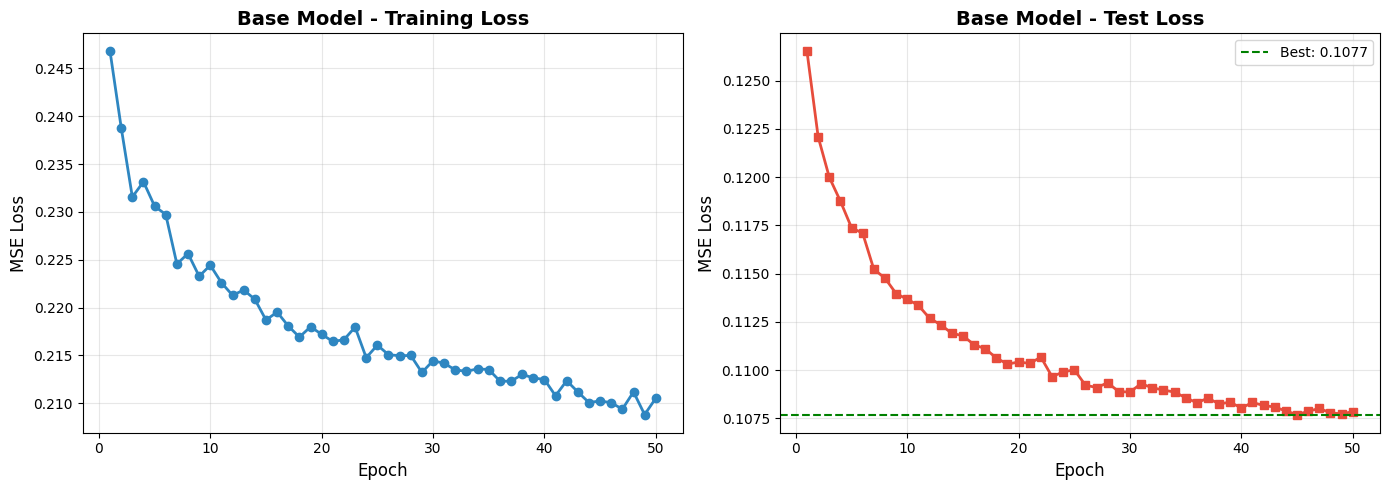

In [21]:
# Plot training and test losses
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Training loss
ax1.plot(range(1, NUM_EPOCHS + 1), base_train_losses, marker='o', linestyle='-', color='#2E86C1', linewidth=2)
ax1.set_title('Base Model - Training Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('MSE Loss', fontsize=12)
ax1.grid(True, alpha=0.3)

# Test loss
ax2.plot(range(1, NUM_EPOCHS + 1), base_test_losses, marker='s', linestyle='-', color='#E74C3C', linewidth=2)
ax2.axhline(y=best_base_loss, color='green', linestyle='--', label=f'Best: {best_base_loss:.4f}')
ax2.set_title('Base Model - Test Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('MSE Loss', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Step 4: Improved Models with Novelties

Implement three novel architectures to improve upon the baseline model.

### 4.1 Novelty 1: Attention-Based Feature Fusion

Instead of simple concatenation, use attention mechanism to dynamically weight headline importance.

In [23]:
class AttentionFinBERTRegressor(nn.Module):
    """
    FinancialBERT with attention-based headline fusion.
    Uses multi-head self-attention to weight headline importance dynamically.
    """
    def __init__(self, model_name="ProsusAI/finbert", hidden_size=768, num_heads=8):
        super(AttentionFinBERTRegressor, self).__init__()
        self.finbert = BertModel.from_pretrained(model_name)
        
        # Freeze FinBERT
        for param in self.finbert.parameters():
            param.requires_grad = False
        
        # Multi-head attention for headline fusion
        self.attention = nn.MultiheadAttention(hidden_size, num_heads, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size)
        
        # Regression head
        self.regressor = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size // 2, 1)
        )
    
    def forward(self, input_ids, attention_mask):
        # Get FinBERT embeddings
        outputs = self.finbert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :].unsqueeze(1)  # (batch, 1, hidden)
        
        # Apply self-attention to weight headline information
        attended, attention_weights = self.attention(cls_embedding, cls_embedding, cls_embedding)
        attended = self.layer_norm(attended + cls_embedding)
        
        # Regression
        output = self.regressor(attended.squeeze(1))
        return output

print("✓ Attention-based model architecture defined")

✓ Attention-based model architecture defined


### 4.2 Novelty 2: Temporal Convolutional Network (TCN)

Add TCN layer to capture temporal dependencies in sequential news data.

In [24]:
class TemporalBlock(nn.Module):
    """
    Temporal Convolutional Block with dilated causal convolutions.
    """
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(TemporalBlock, self).__init__()
        padding = (kernel_size - 1) * dilation
        
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, 
                               padding=padding, dilation=dilation)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        
        # Residual connection
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
    
    def forward(self, x):
        out = self.conv1(x)
        out = out[:, :, :-self.conv1.padding[0]]  # Remove future padding (causal)
        out = self.relu(out)
        out = self.dropout(out)
        
        # Residual
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TCNFinBERTRegressor(nn.Module):
    """
    FinancialBERT with Temporal Convolutional Network.
    Captures temporal dependencies in sequential news embeddings.
    """
    def __init__(self, model_name="ProsusAI/finbert", hidden_size=768, num_channels=[256, 128]):
        super(TCNFinBERTRegressor, self).__init__()
        self.finbert = BertModel.from_pretrained(model_name)
        
        # Freeze FinBERT
        for param in self.finbert.parameters():
            param.requires_grad = False
        
        # TCN layers
        self.tcn_layers = nn.ModuleList()
        in_channels = hidden_size
        for out_channels in num_channels:
            self.tcn_layers.append(TemporalBlock(in_channels, out_channels, kernel_size=3, dilation=1))
            in_channels = out_channels
        
        # Regression head
        self.regressor = nn.Sequential(
            nn.Linear(num_channels[-1], 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 1)
        )
    
    def forward(self, input_ids, attention_mask):
        # Get FinBERT embeddings
        outputs = self.finbert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state  # (batch, seq_len, hidden)
        
        # Reshape for TCN: (batch, hidden, seq_len)
        embeddings = embeddings.permute(0, 2, 1)
        
        # Apply TCN layers
        for tcn_layer in self.tcn_layers:
            embeddings = tcn_layer(embeddings)
        
        # Global average pooling
        pooled = embeddings.mean(dim=2)
        
        # Regression
        output = self.regressor(pooled)
        return output

print("✓ TCN-enhanced model architecture defined")

✓ TCN-enhanced model architecture defined


### 4.3 Novelty 3: Graph Neural Network (GNN)

Model inter-company relationships using graph structure.
*(Simplified version: use graph-aware pooling of embeddings)*

In [25]:
class GraphConvLayer(nn.Module):
    """
    Simple Graph Convolutional Layer.
    Aggregates information from neighboring tokens.
    """
    def __init__(self, in_features, out_features):
        super(GraphConvLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.activation = nn.ReLU()
    
    def forward(self, x, adj=None):
        # x: (batch, seq_len, features)
        # Simple message passing: aggregate neighbor information
        if adj is None:
            # Create fully connected graph (all tokens connected)
            batch_size, seq_len, _ = x.shape
            adj = torch.ones(batch_size, seq_len, seq_len, device=x.device) / seq_len
        
        # Message passing: adj @ x
        aggregated = torch.bmm(adj, x)  # (batch, seq_len, features)
        output = self.linear(aggregated)
        return self.activation(output)


class GNNFinBERTRegressor(nn.Module):
    """
    FinancialBERT with Graph Neural Network.
    Models relationships between different parts of headlines using graph convolutions.
    """
    def __init__(self, model_name="ProsusAI/finbert", hidden_size=768, gnn_layers=2):
        super(GNNFinBERTRegressor, self).__init__()
        self.finbert = BertModel.from_pretrained(model_name)
        
        # Freeze FinBERT
        for param in self.finbert.parameters():
            param.requires_grad = False
        
        # GNN layers
        self.gnn_layers = nn.ModuleList([
            GraphConvLayer(hidden_size, hidden_size) for _ in range(gnn_layers)
        ])
        self.layer_norm = nn.LayerNorm(hidden_size)
        
        # Regression head
        self.regressor = nn.Sequential(
            nn.Linear(hidden_size, 384),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(384, 1)
        )
    
    def forward(self, input_ids, attention_mask):
        # Get FinBERT embeddings
        outputs = self.finbert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state  # (batch, seq_len, hidden)
        
        # Apply GNN layers
        x = embeddings
        for gnn_layer in self.gnn_layers:
            x = gnn_layer(x)
            x = self.layer_norm(x + embeddings)  # Residual connection
        
        # Global pooling (mean + max)
        mean_pool = x.mean(dim=1)
        max_pool, _ = x.max(dim=1)
        pooled = (mean_pool + max_pool) / 2
        
        # Regression
        output = self.regressor(pooled)
        return output

print("✓ GNN-enhanced model architecture defined")

✓ GNN-enhanced model architecture defined


### 4.4 Novelty 4: Hybrid Multi-Branch Model

**Research Motivation**: Combine all three novel approaches in a parallel ensemble architecture.

Each novelty captures different aspects of the data:
- **Attention Branch**: Dynamic importance weighting
- **TCN Branch**: Temporal sequential patterns
- **GNN Branch**: Relational graph structure

The hybrid model processes embeddings through all three branches simultaneously, then fuses the complementary features for final prediction.

In [26]:
class HybridFinBERTRegressor(nn.Module):
    """
    Hybrid Multi-Branch FinancialBERT combining all three novelties.
    
    Architecture:
    1. Shared FinBERT encoder (frozen)
    2. Three parallel branches:
       - Attention Branch: Multi-head self-attention
       - TCN Branch: Temporal convolutional layers
       - GNN Branch: Graph convolutional layers
    3. Feature Fusion: Concatenate all branch outputs
    4. Final Regression Head
    """
    def __init__(self, model_name="ProsusAI/finbert", hidden_size=768):
        super(HybridFinBERTRegressor, self).__init__()
        
        # Shared FinBERT encoder
        self.finbert = BertModel.from_pretrained(model_name)
        for param in self.finbert.parameters():
            param.requires_grad = False
        
        # ============ Branch 1: Attention ============
        self.attention = nn.MultiheadAttention(hidden_size, num_heads=8, batch_first=True)
        self.attn_norm = nn.LayerNorm(hidden_size)
        self.attn_projection = nn.Linear(hidden_size, 256)
        
        # ============ Branch 2: TCN ============
        self.tcn_block1 = TemporalBlock(hidden_size, 256, kernel_size=3, dilation=1)
        self.tcn_block2 = TemporalBlock(256, 128, kernel_size=3, dilation=2)
        
        # ============ Branch 3: GNN ============
        self.gnn_layer1 = GraphConvLayer(hidden_size, 384)
        self.gnn_layer2 = GraphConvLayer(384, 256)
        self.gnn_norm = nn.LayerNorm(256)
        
        # ============ Fusion and Regression ============
        # Total features: 256 (attention) + 128 (TCN) + 256 (GNN) = 640
        self.fusion = nn.Sequential(
            nn.Linear(640, 384),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(384, 128),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        
        self.regressor = nn.Linear(128, 1)
    
    def forward(self, input_ids, attention_mask):
        # Shared FinBERT encoding
        outputs = self.finbert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state  # (batch, seq_len, hidden)
        cls_token = embeddings[:, 0, :].unsqueeze(1)  # (batch, 1, hidden)
        
        # ============ Branch 1: Attention Processing ============
        attn_out, _ = self.attention(cls_token, cls_token, cls_token)
        attn_out = self.attn_norm(attn_out + cls_token)
        attn_features = self.attn_projection(attn_out.squeeze(1))  # (batch, 256)
        
        # ============ Branch 2: TCN Processing ============
        tcn_input = embeddings.permute(0, 2, 1)  # (batch, hidden, seq_len)
        tcn_out = self.tcn_block1(tcn_input)
        tcn_out = self.tcn_block2(tcn_out)
        tcn_features = tcn_out.mean(dim=2)  # Global avg pooling -> (batch, 128)
        
        # ============ Branch 3: GNN Processing ============
        gnn_out = self.gnn_layer1(embeddings)
        gnn_out = self.gnn_layer2(gnn_out)
        gnn_out = self.gnn_norm(gnn_out)
        # Hybrid pooling (mean + max)
        gnn_mean = gnn_out.mean(dim=1)
        gnn_max, _ = gnn_out.max(dim=1)
        gnn_features = (gnn_mean + gnn_max) / 2  # (batch, 256)
        
        # ============ Feature Fusion ============
        combined_features = torch.cat([attn_features, tcn_features, gnn_features], dim=1)  # (batch, 640)
        fused_features = self.fusion(combined_features)  # (batch, 128)
        
        # ============ Final Regression ============
        output = self.regressor(fused_features)
        return output

print("✓ Hybrid Multi-Branch model architecture defined")
print("  - Architecture: Attention + TCN + GNN in parallel")
print("  - Feature fusion: 640 → 384 → 128 → 1")

✓ Hybrid Multi-Branch model architecture defined
  - Architecture: Attention + TCN + GNN in parallel
  - Feature fusion: 640 → 384 → 128 → 1


### 4.5 Train All Improved Models

In [27]:
def train_model(model, model_name, train_loader, test_loader, epochs, device):
    """
    Generic training function for all models.
    """
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
    
    train_losses = []
    test_losses = []
    best_loss = float('inf')
    best_epoch = 0
    
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}\n")
    
    for epoch in range(1, epochs + 1):
        # Training
        model.train()
        epoch_train_loss = 0.0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
        for batch_ids, batch_mask, batch_targets in progress_bar:
            batch_ids = batch_ids.to(device)
            batch_mask = batch_mask.to(device)
            batch_targets = batch_targets.to(device)
            
            optimizer.zero_grad()
            predictions = model(batch_ids, batch_mask)
            loss = criterion(predictions.squeeze(), batch_targets)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            progress_bar.set_postfix({'train_loss': f'{loss.item():.4f}'})
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Evaluation
        model.eval()
        epoch_test_loss = 0.0
        
        with torch.no_grad():
            for batch_ids, batch_mask, batch_targets in test_loader:
                batch_ids = batch_ids.to(device)
                batch_mask = batch_mask.to(device)
                batch_targets = batch_targets.to(device)
                
                predictions = model(batch_ids, batch_mask)
                loss = criterion(predictions.squeeze(), batch_targets)
                epoch_test_loss += loss.item()
        
        avg_test_loss = epoch_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        
        # Save best model
        if avg_test_loss < best_loss:
            best_loss = avg_test_loss
            best_epoch = epoch
            torch.save(model.state_dict(), f'model/{model_name.lower().replace(" ", "_")}_best.pth')
        
        print(f"Epoch {epoch}/{epochs} - Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")
    
    print(f"\n✓ Training complete - Best epoch: {best_epoch}, Best test loss: {best_loss:.4f}\n")
    
    return train_losses, test_losses, best_loss, best_epoch

print("✓ Training function defined")

✓ Training function defined


In [28]:
# Initialize all improved models
attention_model = AttentionFinBERTRegressor()
tcn_model = TCNFinBERTRegressor()
gnn_model = GNNFinBERTRegressor()
hybrid_model = HybridFinBERTRegressor()

# Store results
results = {
    'Base Model': {
        'train_losses': base_train_losses,
        'test_losses': base_test_losses,
        'best_loss': best_base_loss,
        'best_epoch': best_base_epoch
    }
}

print("✓ All improved models initialized")
print(f"  - Attention Model: Multi-head attention fusion")
print(f"  - TCN Model: Temporal convolutional processing")
print(f"  - GNN Model: Graph neural network")
print(f"  - Hybrid Model: All three approaches combined")

✓ All improved models initialized
  - Attention Model: Multi-head attention fusion
  - TCN Model: Temporal convolutional processing
  - GNN Model: Graph neural network
  - Hybrid Model: All three approaches combined


In [29]:
# Train Attention Model
attn_train_losses, attn_test_losses, attn_best_loss, attn_best_epoch = train_model(
    attention_model, "Attention Model", train_dataloader, test_dataloader, NUM_EPOCHS, device
)

results['Attention Model'] = {
    'train_losses': attn_train_losses,
    'test_losses': attn_test_losses,
    'best_loss': attn_best_loss,
    'best_epoch': attn_best_epoch
}


Training Attention Model



Epoch 1/50: 100%|██████████| 949/949 [00:59<00:00, 15.99it/s, train_loss=0.0081] 



Epoch 1/50 - Train Loss: 0.2182, Test Loss: 0.1083


Epoch 2/50: 100%|██████████| 949/949 [01:03<00:00, 15.06it/s, train_loss=0.0220] 



Epoch 2/50 - Train Loss: 0.2128, Test Loss: 0.1073


Epoch 3/50: 100%|██████████| 949/949 [01:01<00:00, 15.34it/s, train_loss=0.0105] 



Epoch 3/50 - Train Loss: 0.2102, Test Loss: 0.1066


Epoch 4/50: 100%|██████████| 949/949 [01:03<00:00, 15.06it/s, train_loss=0.2050] 



Epoch 4/50 - Train Loss: 0.2070, Test Loss: 0.1062


Epoch 5/50: 100%|██████████| 949/949 [01:02<00:00, 15.16it/s, train_loss=0.0141] 



Epoch 5/50 - Train Loss: 0.2060, Test Loss: 0.1057


Epoch 6/50: 100%|██████████| 949/949 [01:00<00:00, 15.58it/s, train_loss=0.0917] 



Epoch 6/50 - Train Loss: 0.2045, Test Loss: 0.1049


Epoch 7/50: 100%|██████████| 949/949 [01:01<00:00, 15.54it/s, train_loss=0.0106] 



Epoch 7/50 - Train Loss: 0.2041, Test Loss: 0.1056


Epoch 8/50: 100%|██████████| 949/949 [01:00<00:00, 15.60it/s, train_loss=0.0332] 



Epoch 8/50 - Train Loss: 0.2031, Test Loss: 0.1058


Epoch 9/50: 100%|██████████| 949/949 [01:00<00:00, 15.62it/s, train_loss=0.0048] 



Epoch 9/50 - Train Loss: 0.2028, Test Loss: 0.1056


Epoch 10/50: 100%|██████████| 949/949 [01:00<00:00, 15.60it/s, train_loss=0.0276] 



Epoch 10/50 - Train Loss: 0.2024, Test Loss: 0.1052


Epoch 11/50: 100%|██████████| 949/949 [01:01<00:00, 15.48it/s, train_loss=0.0070] 



Epoch 11/50 - Train Loss: 0.2017, Test Loss: 0.1053


Epoch 12/50: 100%|██████████| 949/949 [01:00<00:00, 15.60it/s, train_loss=1.3964] 



Epoch 12/50 - Train Loss: 0.2007, Test Loss: 0.1058


Epoch 13/50: 100%|██████████| 949/949 [01:00<00:00, 15.60it/s, train_loss=0.0060] 



Epoch 13/50 - Train Loss: 0.2001, Test Loss: 0.1060


Epoch 14/50: 100%|██████████| 949/949 [01:00<00:00, 15.66it/s, train_loss=0.0153] 



Epoch 14/50 - Train Loss: 0.1992, Test Loss: 0.1058


Epoch 15/50: 100%|██████████| 949/949 [01:00<00:00, 15.56it/s, train_loss=0.0281] 



Epoch 15/50 - Train Loss: 0.1976, Test Loss: 0.1060


Epoch 16/50: 100%|██████████| 949/949 [01:03<00:00, 14.98it/s, train_loss=0.0215] 



Epoch 16/50 - Train Loss: 0.1988, Test Loss: 0.1063


Epoch 17/50: 100%|██████████| 949/949 [01:00<00:00, 15.71it/s, train_loss=0.0226] 



Epoch 17/50 - Train Loss: 0.1981, Test Loss: 0.1054


Epoch 18/50: 100%|██████████| 949/949 [01:01<00:00, 15.52it/s, train_loss=0.0148] 



Epoch 18/50 - Train Loss: 0.1945, Test Loss: 0.1058


Epoch 19/50: 100%|██████████| 949/949 [01:00<00:00, 15.61it/s, train_loss=0.0050] 



Epoch 19/50 - Train Loss: 0.1943, Test Loss: 0.1052


Epoch 20/50: 100%|██████████| 949/949 [01:01<00:00, 15.51it/s, train_loss=0.0314] 



Epoch 20/50 - Train Loss: 0.1951, Test Loss: 0.1066


Epoch 21/50: 100%|██████████| 949/949 [01:00<00:00, 15.59it/s, train_loss=0.0131] 



Epoch 21/50 - Train Loss: 0.1917, Test Loss: 0.1053


Epoch 22/50: 100%|██████████| 949/949 [01:01<00:00, 15.53it/s, train_loss=0.0298] 



Epoch 22/50 - Train Loss: 0.1932, Test Loss: 0.1064


Epoch 23/50: 100%|██████████| 949/949 [01:01<00:00, 15.53it/s, train_loss=0.0527] 



Epoch 23/50 - Train Loss: 0.1918, Test Loss: 0.1056


Epoch 24/50: 100%|██████████| 949/949 [01:01<00:00, 15.52it/s, train_loss=0.0264] 



Epoch 24/50 - Train Loss: 0.1887, Test Loss: 0.1064


Epoch 25/50: 100%|██████████| 949/949 [01:00<00:00, 15.56it/s, train_loss=0.0367] 



Epoch 25/50 - Train Loss: 0.1869, Test Loss: 0.1061


Epoch 26/50: 100%|██████████| 949/949 [01:01<00:00, 15.49it/s, train_loss=0.0141] 



Epoch 26/50 - Train Loss: 0.1869, Test Loss: 0.1058


Epoch 27/50: 100%|██████████| 949/949 [01:00<00:00, 15.60it/s, train_loss=0.0225] 



Epoch 27/50 - Train Loss: 0.1856, Test Loss: 0.1056


Epoch 28/50: 100%|██████████| 949/949 [01:00<00:00, 15.57it/s, train_loss=0.0157] 



Epoch 28/50 - Train Loss: 0.1849, Test Loss: 0.1050


Epoch 29/50: 100%|██████████| 949/949 [01:00<00:00, 15.59it/s, train_loss=0.0168] 



Epoch 29/50 - Train Loss: 0.1823, Test Loss: 0.1057


Epoch 30/50: 100%|██████████| 949/949 [01:01<00:00, 15.53it/s, train_loss=0.0415] 



Epoch 30/50 - Train Loss: 0.1815, Test Loss: 0.1053


Epoch 31/50: 100%|██████████| 949/949 [01:00<00:00, 15.59it/s, train_loss=0.0072] 



Epoch 31/50 - Train Loss: 0.1795, Test Loss: 0.1066


Epoch 32/50: 100%|██████████| 949/949 [01:00<00:00, 15.58it/s, train_loss=0.0044] 



Epoch 32/50 - Train Loss: 0.1780, Test Loss: 0.1064


Epoch 33/50: 100%|██████████| 949/949 [01:00<00:00, 15.56it/s, train_loss=0.0037] 



Epoch 33/50 - Train Loss: 0.1760, Test Loss: 0.1056


Epoch 34/50: 100%|██████████| 949/949 [01:01<00:00, 15.54it/s, train_loss=0.0366] 



Epoch 34/50 - Train Loss: 0.1729, Test Loss: 0.1063


Epoch 35/50: 100%|██████████| 949/949 [01:01<00:00, 15.48it/s, train_loss=0.0086] 



Epoch 35/50 - Train Loss: 0.1751, Test Loss: 0.1062


Epoch 36/50: 100%|██████████| 949/949 [01:00<00:00, 15.60it/s, train_loss=0.0316] 



Epoch 36/50 - Train Loss: 0.1735, Test Loss: 0.1051


Epoch 37/50: 100%|██████████| 949/949 [01:01<00:00, 15.47it/s, train_loss=0.0069] 



Epoch 37/50 - Train Loss: 0.1715, Test Loss: 0.1057


Epoch 38/50: 100%|██████████| 949/949 [01:00<00:00, 15.58it/s, train_loss=0.0057] 



Epoch 38/50 - Train Loss: 0.1659, Test Loss: 0.1067


Epoch 39/50: 100%|██████████| 949/949 [01:01<00:00, 15.51it/s, train_loss=0.0026] 



Epoch 39/50 - Train Loss: 0.1673, Test Loss: 0.1063


Epoch 40/50: 100%|██████████| 949/949 [01:00<00:00, 15.57it/s, train_loss=0.0441] 



Epoch 40/50 - Train Loss: 0.1641, Test Loss: 0.1059


Epoch 41/50: 100%|██████████| 949/949 [01:00<00:00, 15.57it/s, train_loss=0.0516] 



Epoch 41/50 - Train Loss: 0.1657, Test Loss: 0.1086


Epoch 42/50: 100%|██████████| 949/949 [01:00<00:00, 15.57it/s, train_loss=0.0092] 



Epoch 42/50 - Train Loss: 0.1589, Test Loss: 0.1067


Epoch 43/50: 100%|██████████| 949/949 [01:00<00:00, 15.57it/s, train_loss=0.0132] 



Epoch 43/50 - Train Loss: 0.1574, Test Loss: 0.1065


Epoch 44/50: 100%|██████████| 949/949 [01:00<00:00, 15.56it/s, train_loss=0.0196] 



Epoch 44/50 - Train Loss: 0.1562, Test Loss: 0.1080


Epoch 45/50: 100%|██████████| 949/949 [01:00<00:00, 15.56it/s, train_loss=0.0118] 



Epoch 45/50 - Train Loss: 0.1568, Test Loss: 0.1060


Epoch 46/50: 100%|██████████| 949/949 [01:00<00:00, 15.56it/s, train_loss=0.0093] 



Epoch 46/50 - Train Loss: 0.1593, Test Loss: 0.1091


Epoch 47/50: 100%|██████████| 949/949 [01:01<00:00, 15.55it/s, train_loss=0.0471] 



Epoch 47/50 - Train Loss: 0.1511, Test Loss: 0.1050


Epoch 48/50: 100%|██████████| 949/949 [01:01<00:00, 15.49it/s, train_loss=0.0135] 



Epoch 48/50 - Train Loss: 0.1574, Test Loss: 0.1059


Epoch 49/50: 100%|██████████| 949/949 [01:00<00:00, 15.59it/s, train_loss=0.0226] 



Epoch 49/50 - Train Loss: 0.1488, Test Loss: 0.1063


Epoch 50/50: 100%|██████████| 949/949 [01:01<00:00, 15.47it/s, train_loss=0.0161] 



Epoch 50/50 - Train Loss: 0.1497, Test Loss: 0.1094

✓ Training complete - Best epoch: 6, Best test loss: 0.1049



In [30]:
# Train TCN Model
tcn_train_losses, tcn_test_losses, tcn_best_loss, tcn_best_epoch = train_model(
    tcn_model, "TCN Model", train_dataloader, test_dataloader, NUM_EPOCHS, device
)

results['TCN Model'] = {
    'train_losses': tcn_train_losses,
    'test_losses': tcn_test_losses,
    'best_loss': tcn_best_loss,
    'best_epoch': tcn_best_epoch
}


Training TCN Model



Epoch 1/50: 100%|██████████| 949/949 [01:02<00:00, 15.22it/s, train_loss=0.0332] 



Epoch 1/50 - Train Loss: 0.2055, Test Loss: 0.1049


Epoch 2/50: 100%|██████████| 949/949 [01:02<00:00, 15.28it/s, train_loss=0.0184] 



Epoch 2/50 - Train Loss: 0.2049, Test Loss: 0.1048


Epoch 3/50: 100%|██████████| 949/949 [01:01<00:00, 15.36it/s, train_loss=0.0116] 



Epoch 3/50 - Train Loss: 0.2044, Test Loss: 0.1051


Epoch 4/50: 100%|██████████| 949/949 [01:01<00:00, 15.34it/s, train_loss=0.0216] 



Epoch 4/50 - Train Loss: 0.2041, Test Loss: 0.1048


Epoch 5/50: 100%|██████████| 949/949 [01:01<00:00, 15.33it/s, train_loss=0.0101] 



Epoch 5/50 - Train Loss: 0.2038, Test Loss: 0.1049


Epoch 6/50: 100%|██████████| 949/949 [01:01<00:00, 15.34it/s, train_loss=0.0059] 



Epoch 6/50 - Train Loss: 0.2035, Test Loss: 0.1048


Epoch 7/50: 100%|██████████| 949/949 [01:02<00:00, 15.23it/s, train_loss=0.0137] 



Epoch 7/50 - Train Loss: 0.2028, Test Loss: 0.1047


Epoch 8/50: 100%|██████████| 949/949 [01:01<00:00, 15.33it/s, train_loss=0.0239] 



Epoch 8/50 - Train Loss: 0.2025, Test Loss: 0.1043


Epoch 9/50: 100%|██████████| 949/949 [01:02<00:00, 15.29it/s, train_loss=0.0462] 



Epoch 9/50 - Train Loss: 0.2023, Test Loss: 0.1046


Epoch 10/50: 100%|██████████| 949/949 [01:01<00:00, 15.35it/s, train_loss=0.0218] 



Epoch 10/50 - Train Loss: 0.2016, Test Loss: 0.1041


Epoch 11/50: 100%|██████████| 949/949 [01:02<00:00, 15.19it/s, train_loss=0.0127] 



Epoch 11/50 - Train Loss: 0.2012, Test Loss: 0.1047


Epoch 12/50: 100%|██████████| 949/949 [01:01<00:00, 15.37it/s, train_loss=0.0031] 



Epoch 12/50 - Train Loss: 0.2000, Test Loss: 0.1039


Epoch 13/50: 100%|██████████| 949/949 [01:02<00:00, 15.19it/s, train_loss=0.0013] 



Epoch 13/50 - Train Loss: 0.1998, Test Loss: 0.1063


Epoch 14/50: 100%|██████████| 949/949 [01:01<00:00, 15.33it/s, train_loss=0.0767] 



Epoch 14/50 - Train Loss: 0.1999, Test Loss: 0.1037


Epoch 15/50: 100%|██████████| 949/949 [01:02<00:00, 15.27it/s, train_loss=0.0138] 



Epoch 15/50 - Train Loss: 0.1988, Test Loss: 0.1033


Epoch 16/50: 100%|██████████| 949/949 [01:01<00:00, 15.33it/s, train_loss=0.0186] 



Epoch 16/50 - Train Loss: 0.1979, Test Loss: 0.1037


Epoch 17/50: 100%|██████████| 949/949 [01:01<00:00, 15.31it/s, train_loss=0.0228] 



Epoch 17/50 - Train Loss: 0.1965, Test Loss: 0.1034


Epoch 18/50: 100%|██████████| 949/949 [01:02<00:00, 15.30it/s, train_loss=0.0097] 



Epoch 18/50 - Train Loss: 0.1952, Test Loss: 0.1033


Epoch 19/50: 100%|██████████| 949/949 [01:01<00:00, 15.31it/s, train_loss=0.0507] 



Epoch 19/50 - Train Loss: 0.1945, Test Loss: 0.1031


Epoch 20/50: 100%|██████████| 949/949 [01:01<00:00, 15.31it/s, train_loss=0.0332] 



Epoch 20/50 - Train Loss: 0.1944, Test Loss: 0.1034


Epoch 21/50: 100%|██████████| 949/949 [01:01<00:00, 15.31it/s, train_loss=0.0010] 



Epoch 21/50 - Train Loss: 0.1930, Test Loss: 0.1034


Epoch 22/50: 100%|██████████| 949/949 [01:01<00:00, 15.32it/s, train_loss=0.0821] 



Epoch 22/50 - Train Loss: 0.1920, Test Loss: 0.1028


Epoch 23/50: 100%|██████████| 949/949 [01:01<00:00, 15.37it/s, train_loss=0.0074] 



Epoch 23/50 - Train Loss: 0.1894, Test Loss: 0.1034


Epoch 24/50: 100%|██████████| 949/949 [01:02<00:00, 15.29it/s, train_loss=0.0216] 



Epoch 24/50 - Train Loss: 0.1883, Test Loss: 0.1095


Epoch 25/50: 100%|██████████| 949/949 [01:01<00:00, 15.33it/s, train_loss=0.0068] 



Epoch 25/50 - Train Loss: 0.1893, Test Loss: 0.1034


Epoch 26/50: 100%|██████████| 949/949 [01:01<00:00, 15.31it/s, train_loss=0.0137] 



Epoch 26/50 - Train Loss: 0.1867, Test Loss: 0.1024


Epoch 27/50: 100%|██████████| 949/949 [01:01<00:00, 15.31it/s, train_loss=0.0058] 



Epoch 27/50 - Train Loss: 0.1855, Test Loss: 0.1031


Epoch 28/50: 100%|██████████| 949/949 [01:01<00:00, 15.32it/s, train_loss=0.0112] 



Epoch 28/50 - Train Loss: 0.1825, Test Loss: 0.1032


Epoch 29/50: 100%|██████████| 949/949 [01:01<00:00, 15.32it/s, train_loss=0.0084] 



Epoch 29/50 - Train Loss: 0.1832, Test Loss: 0.1028


Epoch 30/50: 100%|██████████| 949/949 [01:01<00:00, 15.35it/s, train_loss=0.0090] 



Epoch 30/50 - Train Loss: 0.1803, Test Loss: 0.1026


Epoch 31/50: 100%|██████████| 949/949 [01:01<00:00, 15.35it/s, train_loss=0.0193] 



Epoch 31/50 - Train Loss: 0.1785, Test Loss: 0.1030


Epoch 32/50: 100%|██████████| 949/949 [01:01<00:00, 15.35it/s, train_loss=0.0352] 



Epoch 32/50 - Train Loss: 0.1766, Test Loss: 0.1052


Epoch 33/50: 100%|██████████| 949/949 [01:01<00:00, 15.32it/s, train_loss=0.0054] 



Epoch 33/50 - Train Loss: 0.1748, Test Loss: 0.1034


Epoch 34/50: 100%|██████████| 949/949 [01:02<00:00, 15.31it/s, train_loss=0.0166] 



Epoch 34/50 - Train Loss: 0.1723, Test Loss: 0.1033


Epoch 35/50: 100%|██████████| 949/949 [01:01<00:00, 15.35it/s, train_loss=0.0335] 



Epoch 35/50 - Train Loss: 0.1691, Test Loss: 0.1039


Epoch 36/50: 100%|██████████| 949/949 [01:01<00:00, 15.35it/s, train_loss=0.0056] 



Epoch 36/50 - Train Loss: 0.1687, Test Loss: 0.1032


Epoch 37/50: 100%|██████████| 949/949 [01:01<00:00, 15.36it/s, train_loss=0.5929] 



Epoch 37/50 - Train Loss: 0.1642, Test Loss: 0.1066


Epoch 38/50: 100%|██████████| 949/949 [01:01<00:00, 15.32it/s, train_loss=0.0222] 



Epoch 38/50 - Train Loss: 0.1601, Test Loss: 0.1218


Epoch 39/50: 100%|██████████| 949/949 [01:01<00:00, 15.33it/s, train_loss=0.0008] 



Epoch 39/50 - Train Loss: 0.1585, Test Loss: 0.1044


Epoch 40/50: 100%|██████████| 949/949 [01:01<00:00, 15.33it/s, train_loss=0.0094] 



Epoch 40/50 - Train Loss: 0.1628, Test Loss: 0.1051


Epoch 41/50: 100%|██████████| 949/949 [01:01<00:00, 15.34it/s, train_loss=0.0107] 



Epoch 41/50 - Train Loss: 0.1570, Test Loss: 0.1040


Epoch 42/50: 100%|██████████| 949/949 [01:01<00:00, 15.34it/s, train_loss=0.0107] 



Epoch 42/50 - Train Loss: 0.1575, Test Loss: 0.1053


Epoch 43/50: 100%|██████████| 949/949 [01:01<00:00, 15.35it/s, train_loss=0.0217] 



Epoch 43/50 - Train Loss: 0.1439, Test Loss: 0.1048


Epoch 44/50: 100%|██████████| 949/949 [01:01<00:00, 15.34it/s, train_loss=0.0206] 



Epoch 44/50 - Train Loss: 0.1458, Test Loss: 0.1117


Epoch 45/50: 100%|██████████| 949/949 [01:01<00:00, 15.34it/s, train_loss=0.0150] 



Epoch 45/50 - Train Loss: 0.1447, Test Loss: 0.1048


Epoch 46/50: 100%|██████████| 949/949 [01:01<00:00, 15.32it/s, train_loss=0.0557] 



Epoch 46/50 - Train Loss: 0.1391, Test Loss: 0.1048


Epoch 47/50: 100%|██████████| 949/949 [01:01<00:00, 15.38it/s, train_loss=0.1380] 



Epoch 47/50 - Train Loss: 0.1397, Test Loss: 0.1161


Epoch 48/50: 100%|██████████| 949/949 [01:01<00:00, 15.37it/s, train_loss=0.0224] 



Epoch 48/50 - Train Loss: 0.1392, Test Loss: 0.1070


Epoch 49/50: 100%|██████████| 949/949 [01:01<00:00, 15.35it/s, train_loss=0.0317] 



Epoch 49/50 - Train Loss: 0.1319, Test Loss: 0.1130


Epoch 50/50: 100%|██████████| 949/949 [01:01<00:00, 15.42it/s, train_loss=0.0113] 



Epoch 50/50 - Train Loss: 0.1379, Test Loss: 0.1069

✓ Training complete - Best epoch: 26, Best test loss: 0.1024



In [31]:
# Train GNN Model
gnn_train_losses, gnn_test_losses, gnn_best_loss, gnn_best_epoch = train_model(
    gnn_model, "GNN Model", train_dataloader, test_dataloader, NUM_EPOCHS, device
)

results['GNN Model'] = {
    'train_losses': gnn_train_losses,
    'test_losses': gnn_test_losses,
    'best_loss': gnn_best_loss,
    'best_epoch': gnn_best_epoch
}


Training GNN Model



Epoch 1/50: 100%|██████████| 949/949 [01:03<00:00, 15.04it/s, train_loss=0.0535] 



Epoch 1/50 - Train Loss: 0.2135, Test Loss: 0.1064


Epoch 2/50: 100%|██████████| 949/949 [01:02<00:00, 15.16it/s, train_loss=0.0021] 



Epoch 2/50 - Train Loss: 0.2083, Test Loss: 0.1064


Epoch 3/50: 100%|██████████| 949/949 [01:02<00:00, 15.07it/s, train_loss=0.0247] 



Epoch 3/50 - Train Loss: 0.2062, Test Loss: 0.1064


Epoch 4/50: 100%|██████████| 949/949 [01:02<00:00, 15.20it/s, train_loss=0.0108] 



Epoch 4/50 - Train Loss: 0.2045, Test Loss: 0.1068


Epoch 5/50: 100%|██████████| 949/949 [01:02<00:00, 15.13it/s, train_loss=0.0333] 



Epoch 5/50 - Train Loss: 0.2039, Test Loss: 0.1049


Epoch 6/50: 100%|██████████| 949/949 [01:02<00:00, 15.14it/s, train_loss=0.0150] 



Epoch 6/50 - Train Loss: 0.2029, Test Loss: 0.1043


Epoch 7/50: 100%|██████████| 949/949 [01:02<00:00, 15.07it/s, train_loss=0.0179] 



Epoch 7/50 - Train Loss: 0.2017, Test Loss: 0.1041


Epoch 8/50: 100%|██████████| 949/949 [01:02<00:00, 15.18it/s, train_loss=0.0365] 



Epoch 8/50 - Train Loss: 0.2013, Test Loss: 0.1043


Epoch 9/50: 100%|██████████| 949/949 [01:02<00:00, 15.18it/s, train_loss=0.3367] 



Epoch 9/50 - Train Loss: 0.2018, Test Loss: 0.1039


Epoch 10/50: 100%|██████████| 949/949 [01:02<00:00, 15.07it/s, train_loss=0.0091] 



Epoch 10/50 - Train Loss: 0.1997, Test Loss: 0.1046


Epoch 11/50: 100%|██████████| 949/949 [01:02<00:00, 15.12it/s, train_loss=0.0047] 



Epoch 11/50 - Train Loss: 0.1995, Test Loss: 0.1051


Epoch 12/50: 100%|██████████| 949/949 [01:02<00:00, 15.11it/s, train_loss=0.0487] 



Epoch 12/50 - Train Loss: 0.1985, Test Loss: 0.1032


Epoch 13/50: 100%|██████████| 949/949 [01:02<00:00, 15.12it/s, train_loss=0.0441] 



Epoch 13/50 - Train Loss: 0.1977, Test Loss: 0.1044


Epoch 14/50: 100%|██████████| 949/949 [01:02<00:00, 15.11it/s, train_loss=0.0038] 



Epoch 14/50 - Train Loss: 0.1965, Test Loss: 0.1028


Epoch 15/50: 100%|██████████| 949/949 [01:02<00:00, 15.11it/s, train_loss=0.0021] 



Epoch 15/50 - Train Loss: 0.1953, Test Loss: 0.1036


Epoch 16/50: 100%|██████████| 949/949 [01:02<00:00, 15.13it/s, train_loss=0.0038] 



Epoch 16/50 - Train Loss: 0.1962, Test Loss: 0.1027


Epoch 17/50: 100%|██████████| 949/949 [01:02<00:00, 15.16it/s, train_loss=0.0454] 



Epoch 17/50 - Train Loss: 0.1950, Test Loss: 0.1079


Epoch 18/50: 100%|██████████| 949/949 [01:03<00:00, 14.86it/s, train_loss=0.0188] 



Epoch 18/50 - Train Loss: 0.1939, Test Loss: 0.1058


Epoch 19/50: 100%|██████████| 949/949 [01:03<00:00, 15.02it/s, train_loss=0.0027] 



Epoch 19/50 - Train Loss: 0.1921, Test Loss: 0.1039


Epoch 20/50: 100%|██████████| 949/949 [01:02<00:00, 15.18it/s, train_loss=0.0305] 



Epoch 20/50 - Train Loss: 0.1910, Test Loss: 0.1040


Epoch 21/50: 100%|██████████| 949/949 [01:02<00:00, 15.10it/s, train_loss=0.0192] 



Epoch 21/50 - Train Loss: 0.1889, Test Loss: 0.1030


Epoch 22/50: 100%|██████████| 949/949 [01:02<00:00, 15.16it/s, train_loss=0.0350] 



Epoch 22/50 - Train Loss: 0.1899, Test Loss: 0.1191


Epoch 23/50: 100%|██████████| 949/949 [01:02<00:00, 15.08it/s, train_loss=0.0085] 



Epoch 23/50 - Train Loss: 0.1878, Test Loss: 0.1043


Epoch 24/50: 100%|██████████| 949/949 [01:02<00:00, 15.12it/s, train_loss=0.0287] 



Epoch 24/50 - Train Loss: 0.1858, Test Loss: 0.1039


Epoch 25/50: 100%|██████████| 949/949 [01:02<00:00, 15.07it/s, train_loss=0.0253] 



Epoch 25/50 - Train Loss: 0.1843, Test Loss: 0.1026


Epoch 26/50: 100%|██████████| 949/949 [01:02<00:00, 15.15it/s, train_loss=0.0468] 



Epoch 26/50 - Train Loss: 0.1834, Test Loss: 0.1042


Epoch 27/50: 100%|██████████| 949/949 [01:02<00:00, 15.13it/s, train_loss=0.0027] 



Epoch 27/50 - Train Loss: 0.1816, Test Loss: 0.1035


Epoch 28/50: 100%|██████████| 949/949 [01:02<00:00, 15.12it/s, train_loss=0.0102] 



Epoch 28/50 - Train Loss: 0.1803, Test Loss: 0.1039


Epoch 29/50: 100%|██████████| 949/949 [01:02<00:00, 15.11it/s, train_loss=0.0063] 



Epoch 29/50 - Train Loss: 0.1781, Test Loss: 0.1029


Epoch 30/50: 100%|██████████| 949/949 [01:03<00:00, 15.06it/s, train_loss=0.0560] 



Epoch 30/50 - Train Loss: 0.1751, Test Loss: 0.1036


Epoch 31/50: 100%|██████████| 949/949 [01:02<00:00, 15.15it/s, train_loss=0.0089] 



Epoch 31/50 - Train Loss: 0.1751, Test Loss: 0.1031


Epoch 32/50: 100%|██████████| 949/949 [01:02<00:00, 15.10it/s, train_loss=0.0125] 



Epoch 32/50 - Train Loss: 0.1735, Test Loss: 0.1034


Epoch 33/50: 100%|██████████| 949/949 [01:02<00:00, 15.20it/s, train_loss=0.0085] 



Epoch 33/50 - Train Loss: 0.1702, Test Loss: 0.1067


Epoch 34/50: 100%|██████████| 949/949 [01:03<00:00, 15.06it/s, train_loss=0.0048] 



Epoch 34/50 - Train Loss: 0.1676, Test Loss: 0.1036


Epoch 35/50: 100%|██████████| 949/949 [01:02<00:00, 15.12it/s, train_loss=0.1210] 



Epoch 35/50 - Train Loss: 0.1675, Test Loss: 0.1082


Epoch 36/50: 100%|██████████| 949/949 [01:02<00:00, 15.11it/s, train_loss=0.0360] 



Epoch 36/50 - Train Loss: 0.1633, Test Loss: 0.1056


Epoch 37/50: 100%|██████████| 949/949 [01:02<00:00, 15.13it/s, train_loss=0.4063] 



Epoch 37/50 - Train Loss: 0.1601, Test Loss: 0.1033


Epoch 38/50: 100%|██████████| 949/949 [01:02<00:00, 15.17it/s, train_loss=0.0138] 



Epoch 38/50 - Train Loss: 0.1602, Test Loss: 0.1044


Epoch 39/50: 100%|██████████| 949/949 [01:02<00:00, 15.13it/s, train_loss=0.0565] 



Epoch 39/50 - Train Loss: 0.1544, Test Loss: 0.1052


Epoch 40/50: 100%|██████████| 949/949 [01:02<00:00, 15.17it/s, train_loss=0.0087] 



Epoch 40/50 - Train Loss: 0.1498, Test Loss: 0.1035


Epoch 41/50: 100%|██████████| 949/949 [01:02<00:00, 15.12it/s, train_loss=0.0103] 



Epoch 41/50 - Train Loss: 0.1522, Test Loss: 0.1041


Epoch 42/50: 100%|██████████| 949/949 [01:02<00:00, 15.11it/s, train_loss=0.0109] 



Epoch 42/50 - Train Loss: 0.1455, Test Loss: 0.1063


Epoch 43/50: 100%|██████████| 949/949 [01:02<00:00, 15.10it/s, train_loss=0.0060] 



Epoch 43/50 - Train Loss: 0.1452, Test Loss: 0.1048


Epoch 44/50: 100%|██████████| 949/949 [01:02<00:00, 15.12it/s, train_loss=0.0031] 



Epoch 44/50 - Train Loss: 0.1424, Test Loss: 0.1031


Epoch 45/50: 100%|██████████| 949/949 [01:02<00:00, 15.11it/s, train_loss=0.0463] 



Epoch 45/50 - Train Loss: 0.1342, Test Loss: 0.1036


Epoch 46/50: 100%|██████████| 949/949 [01:02<00:00, 15.17it/s, train_loss=0.0304] 



Epoch 46/50 - Train Loss: 0.1302, Test Loss: 0.1077


Epoch 47/50: 100%|██████████| 949/949 [01:02<00:00, 15.19it/s, train_loss=0.0425] 



Epoch 47/50 - Train Loss: 0.1351, Test Loss: 0.1061


Epoch 48/50: 100%|██████████| 949/949 [01:02<00:00, 15.10it/s, train_loss=0.0206] 



Epoch 48/50 - Train Loss: 0.1265, Test Loss: 0.1075


Epoch 49/50: 100%|██████████| 949/949 [01:02<00:00, 15.12it/s, train_loss=0.0018] 



Epoch 49/50 - Train Loss: 0.1185, Test Loss: 0.1039


Epoch 50/50: 100%|██████████| 949/949 [01:02<00:00, 15.10it/s, train_loss=0.0739] 



Epoch 50/50 - Train Loss: 0.1190, Test Loss: 0.1029

✓ Training complete - Best epoch: 25, Best test loss: 0.1026



In [32]:
# Train Hybrid Multi-Branch Model
hybrid_train_losses, hybrid_test_losses, hybrid_best_loss, hybrid_best_epoch = train_model(
    hybrid_model, "Hybrid Model", train_dataloader, test_dataloader, NUM_EPOCHS, device
)

results['Hybrid Model'] = {
    'train_losses': hybrid_train_losses,
    'test_losses': hybrid_test_losses,
    'best_loss': hybrid_best_loss,
    'best_epoch': hybrid_best_epoch
}


Training Hybrid Model



Epoch 1/50: 100%|██████████| 949/949 [01:04<00:00, 14.77it/s, train_loss=0.0043] 



Epoch 1/50 - Train Loss: 0.2064, Test Loss: 0.1047


Epoch 2/50: 100%|██████████| 949/949 [01:04<00:00, 14.72it/s, train_loss=0.0561] 



Epoch 2/50 - Train Loss: 0.2048, Test Loss: 0.1052


Epoch 3/50: 100%|██████████| 949/949 [01:03<00:00, 14.83it/s, train_loss=0.0073] 



Epoch 3/50 - Train Loss: 0.2040, Test Loss: 0.1051


Epoch 4/50: 100%|██████████| 949/949 [01:05<00:00, 14.43it/s, train_loss=0.0147] 



Epoch 4/50 - Train Loss: 0.2039, Test Loss: 0.1043


Epoch 5/50: 100%|██████████| 949/949 [01:04<00:00, 14.70it/s, train_loss=0.0081] 



Epoch 5/50 - Train Loss: 0.2027, Test Loss: 0.1042


Epoch 6/50: 100%|██████████| 949/949 [01:04<00:00, 14.82it/s, train_loss=0.0535] 



Epoch 6/50 - Train Loss: 0.2025, Test Loss: 0.1037


Epoch 7/50: 100%|██████████| 949/949 [01:04<00:00, 14.75it/s, train_loss=0.0458] 



Epoch 7/50 - Train Loss: 0.2023, Test Loss: 0.1041


Epoch 8/50: 100%|██████████| 949/949 [01:04<00:00, 14.81it/s, train_loss=0.0041] 



Epoch 8/50 - Train Loss: 0.2009, Test Loss: 0.1047


Epoch 9/50: 100%|██████████| 949/949 [01:04<00:00, 14.71it/s, train_loss=0.0162] 



Epoch 9/50 - Train Loss: 0.1996, Test Loss: 0.1077


Epoch 10/50: 100%|██████████| 949/949 [01:04<00:00, 14.80it/s, train_loss=0.1675] 



Epoch 10/50 - Train Loss: 0.1987, Test Loss: 0.1048


Epoch 11/50: 100%|██████████| 949/949 [01:04<00:00, 14.66it/s, train_loss=0.0090] 



Epoch 11/50 - Train Loss: 0.1966, Test Loss: 0.1067


Epoch 12/50: 100%|██████████| 949/949 [01:04<00:00, 14.75it/s, train_loss=0.1711] 



Epoch 12/50 - Train Loss: 0.1960, Test Loss: 0.1046


Epoch 13/50: 100%|██████████| 949/949 [01:04<00:00, 14.81it/s, train_loss=0.0146] 



Epoch 13/50 - Train Loss: 0.1927, Test Loss: 0.1051


Epoch 14/50: 100%|██████████| 949/949 [01:04<00:00, 14.81it/s, train_loss=0.0339] 



Epoch 14/50 - Train Loss: 0.1934, Test Loss: 0.1045


Epoch 15/50: 100%|██████████| 949/949 [01:04<00:00, 14.81it/s, train_loss=0.0170] 



Epoch 15/50 - Train Loss: 0.1870, Test Loss: 0.1039


Epoch 16/50: 100%|██████████| 949/949 [01:04<00:00, 14.74it/s, train_loss=0.0160] 



Epoch 16/50 - Train Loss: 0.1848, Test Loss: 0.1046


Epoch 17/50: 100%|██████████| 949/949 [01:04<00:00, 14.81it/s, train_loss=0.0383] 



Epoch 17/50 - Train Loss: 0.1838, Test Loss: 0.1043


Epoch 18/50: 100%|██████████| 949/949 [01:04<00:00, 14.80it/s, train_loss=0.2378] 



Epoch 18/50 - Train Loss: 0.1764, Test Loss: 0.1071


Epoch 19/50: 100%|██████████| 949/949 [01:04<00:00, 14.74it/s, train_loss=0.0363] 



Epoch 19/50 - Train Loss: 0.1715, Test Loss: 0.1041


Epoch 20/50: 100%|██████████| 949/949 [01:03<00:00, 14.83it/s, train_loss=0.0699] 



Epoch 20/50 - Train Loss: 0.1671, Test Loss: 0.1070


Epoch 21/50: 100%|██████████| 949/949 [01:04<00:00, 14.79it/s, train_loss=0.0057] 



Epoch 21/50 - Train Loss: 0.1603, Test Loss: 0.1037


Epoch 22/50: 100%|██████████| 949/949 [01:04<00:00, 14.78it/s, train_loss=0.0526] 



Epoch 22/50 - Train Loss: 0.1603, Test Loss: 0.1038


Epoch 23/50: 100%|██████████| 949/949 [4:29:23<00:00, 17.03s/it, train_loss=0.0180]     



Epoch 23/50 - Train Loss: 0.1446, Test Loss: 0.1042


Epoch 24/50: 100%|██████████| 949/949 [01:00<00:00, 15.62it/s, train_loss=0.0049] 



Epoch 24/50 - Train Loss: 0.1412, Test Loss: 0.1037


Epoch 25/50: 100%|██████████| 949/949 [00:59<00:00, 15.93it/s, train_loss=0.0100] 



Epoch 25/50 - Train Loss: 0.1386, Test Loss: 0.1045


Epoch 26/50: 100%|██████████| 949/949 [00:59<00:00, 15.99it/s, train_loss=0.0181] 



Epoch 26/50 - Train Loss: 0.1278, Test Loss: 0.1052


Epoch 27/50: 100%|██████████| 949/949 [00:59<00:00, 15.84it/s, train_loss=0.0124] 



Epoch 27/50 - Train Loss: 0.1184, Test Loss: 0.1041


Epoch 28/50: 100%|██████████| 949/949 [00:59<00:00, 15.89it/s, train_loss=0.0916] 



Epoch 28/50 - Train Loss: 0.1072, Test Loss: 0.1038


Epoch 29/50: 100%|██████████| 949/949 [01:00<00:00, 15.80it/s, train_loss=0.0331] 



Epoch 29/50 - Train Loss: 0.1008, Test Loss: 0.1040


Epoch 30/50: 100%|██████████| 949/949 [01:00<00:00, 15.61it/s, train_loss=0.1030] 



Epoch 30/50 - Train Loss: 0.1042, Test Loss: 0.1044


Epoch 31/50: 100%|██████████| 949/949 [01:01<00:00, 15.46it/s, train_loss=0.0146] 



Epoch 31/50 - Train Loss: 0.0873, Test Loss: 0.1041


Epoch 32/50: 100%|██████████| 949/949 [01:01<00:00, 15.41it/s, train_loss=0.9922] 



Epoch 32/50 - Train Loss: 0.0849, Test Loss: 0.1040


Epoch 33/50: 100%|██████████| 949/949 [01:01<00:00, 15.32it/s, train_loss=0.0071] 



Epoch 33/50 - Train Loss: 0.0869, Test Loss: 0.1035


Epoch 34/50: 100%|██████████| 949/949 [01:02<00:00, 15.20it/s, train_loss=0.0076] 



Epoch 34/50 - Train Loss: 0.0803, Test Loss: 0.1039


Epoch 35/50: 100%|██████████| 949/949 [01:02<00:00, 15.22it/s, train_loss=0.0484]



Epoch 35/50 - Train Loss: 0.0648, Test Loss: 0.1037


Epoch 36/50: 100%|██████████| 949/949 [01:02<00:00, 15.20it/s, train_loss=0.0047]



Epoch 36/50 - Train Loss: 0.0604, Test Loss: 0.1036


Epoch 37/50: 100%|██████████| 949/949 [01:02<00:00, 15.14it/s, train_loss=0.0136]



Epoch 37/50 - Train Loss: 0.0570, Test Loss: 0.1039


Epoch 38/50: 100%|██████████| 949/949 [01:02<00:00, 15.08it/s, train_loss=0.0071]



Epoch 38/50 - Train Loss: 0.0570, Test Loss: 0.1035


Epoch 39/50: 100%|██████████| 949/949 [01:03<00:00, 14.97it/s, train_loss=0.0361]



Epoch 39/50 - Train Loss: 0.0595, Test Loss: 0.1031


Epoch 40/50: 100%|██████████| 949/949 [01:02<00:00, 15.14it/s, train_loss=0.0654]



Epoch 40/50 - Train Loss: 0.0478, Test Loss: 0.1037


Epoch 41/50: 100%|██████████| 949/949 [01:02<00:00, 15.09it/s, train_loss=0.0016]



Epoch 41/50 - Train Loss: 0.0522, Test Loss: 0.1040


Epoch 42/50: 100%|██████████| 949/949 [01:03<00:00, 15.04it/s, train_loss=0.0232]



Epoch 42/50 - Train Loss: 0.0515, Test Loss: 0.1031


Epoch 43/50: 100%|██████████| 949/949 [01:03<00:00, 15.02it/s, train_loss=0.0276]



Epoch 43/50 - Train Loss: 0.0487, Test Loss: 0.1026


Epoch 44/50: 100%|██████████| 949/949 [01:03<00:00, 15.06it/s, train_loss=0.0180]



Epoch 44/50 - Train Loss: 0.0470, Test Loss: 0.1065


Epoch 45/50: 100%|██████████| 949/949 [01:03<00:00, 15.01it/s, train_loss=0.0132]



Epoch 45/50 - Train Loss: 0.0562, Test Loss: 0.1029


Epoch 46/50: 100%|██████████| 949/949 [01:03<00:00, 14.96it/s, train_loss=0.0277]



Epoch 46/50 - Train Loss: 0.0471, Test Loss: 0.1028


Epoch 47/50: 100%|██████████| 949/949 [01:03<00:00, 15.01it/s, train_loss=0.0807]



Epoch 47/50 - Train Loss: 0.0483, Test Loss: 0.1032


Epoch 48/50: 100%|██████████| 949/949 [01:03<00:00, 14.98it/s, train_loss=0.0024]



Epoch 48/50 - Train Loss: 0.0495, Test Loss: 0.1028


Epoch 49/50: 100%|██████████| 949/949 [01:03<00:00, 15.02it/s, train_loss=0.0245]



Epoch 49/50 - Train Loss: 0.0466, Test Loss: 0.1024


Epoch 50/50: 100%|██████████| 949/949 [01:03<00:00, 14.98it/s, train_loss=0.1329]



Epoch 50/50 - Train Loss: 0.0464, Test Loss: 0.1023

✓ Training complete - Best epoch: 50, Best test loss: 0.1023



In [33]:
# Consolidate all results in the dictionary
results['Attention Model'] = {
    'train_losses': attn_train_losses,
    'test_losses': attn_test_losses,
    'best_loss': attn_best_loss,
    'best_epoch': attn_best_epoch
}

results['TCN Model'] = {
    'train_losses': tcn_train_losses,
    'test_losses': tcn_test_losses,
    'best_loss': tcn_best_loss,
    'best_epoch': tcn_best_epoch
}

results['GNN Model'] = {
    'train_losses': gnn_train_losses,
    'test_losses': gnn_test_losses,
    'best_loss': gnn_best_loss,
    'best_epoch': gnn_best_epoch
}

print("✓ All results consolidated in results dictionary")

✓ All results consolidated in results dictionary


---
## Step 5: Comprehensive Model Comparison

Evaluate and compare all models on the same test dataset.

### 5.1 Evaluate All Models on Test Set

In [34]:
def evaluate_model(model, model_path, test_loader, device):
    """
    Evaluate model and return predictions and actuals.
    """
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_ids, batch_mask, batch_targets in test_loader:
            batch_ids = batch_ids.to(device)
            batch_mask = batch_mask.to(device)
            
            preds = model(batch_ids, batch_mask)
            predictions.extend(preds.squeeze().cpu().numpy())
            actuals.extend(batch_targets.numpy())
    
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # Calculate metrics
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    
    return predictions, actuals, {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

print("✓ Evaluation function defined")

✓ Evaluation function defined


In [35]:
# Evaluate all models
model_configs = [
    (base_model, 'model/base_model_best.pth', 'Base Model'),
    (attention_model, 'model/attention_model_best.pth', 'Attention Model'),
    (tcn_model, 'model/tcn_model_best.pth', 'TCN Model'),
    (gnn_model, 'model/gnn_model_best.pth', 'GNN Model'),
    (hybrid_model, 'model/hybrid_model_best.pth', 'Hybrid Model')
]

all_predictions = {}
all_metrics = {}

print(f"\n{'='*60}")
print("Evaluating All Models on Test Set")
print(f"{'='*60}\n")

for model, model_path, model_name in model_configs:
    preds, acts, metrics = evaluate_model(model, model_path, test_dataloader, device)
    all_predictions[model_name] = preds
    all_metrics[model_name] = metrics
    
    print(f"{model_name}:")
    print(f"  MSE:  {metrics['MSE']:.6f}")
    print(f"  RMSE: {metrics['RMSE']:.6f}")
    print(f"  MAE:  {metrics['MAE']:.6f}")
    print(f"  R²:   {metrics['R2']:.6f}")
    print()

print(f"{'='*60}\n")


Evaluating All Models on Test Set

Base Model:
  MSE:  0.107719
  RMSE: 0.328206
  MAE:  0.134810
  R²:   -0.018391

Base Model:
  MSE:  0.107719
  RMSE: 0.328206
  MAE:  0.134810
  R²:   -0.018391

Attention Model:
  MSE:  0.104790
  RMSE: 0.323713
  MAE:  0.128392
  R²:   0.009302

Attention Model:
  MSE:  0.104790
  RMSE: 0.323713
  MAE:  0.128392
  R²:   0.009302

TCN Model:
  MSE:  0.102345
  RMSE: 0.319914
  MAE:  0.122185
  R²:   0.032418

TCN Model:
  MSE:  0.102345
  RMSE: 0.319914
  MAE:  0.122185
  R²:   0.032418

GNN Model:
  MSE:  0.102548
  RMSE: 0.320231
  MAE:  0.124926
  R²:   0.030502

GNN Model:
  MSE:  0.102548
  RMSE: 0.320231
  MAE:  0.124926
  R²:   0.030502

Hybrid Model:
  MSE:  0.102235
  RMSE: 0.319742
  MAE:  0.120118
  R²:   0.033463


Hybrid Model:
  MSE:  0.102235
  RMSE: 0.319742
  MAE:  0.120118
  R²:   0.033463




### 5.2 Performance Comparison Visualizations

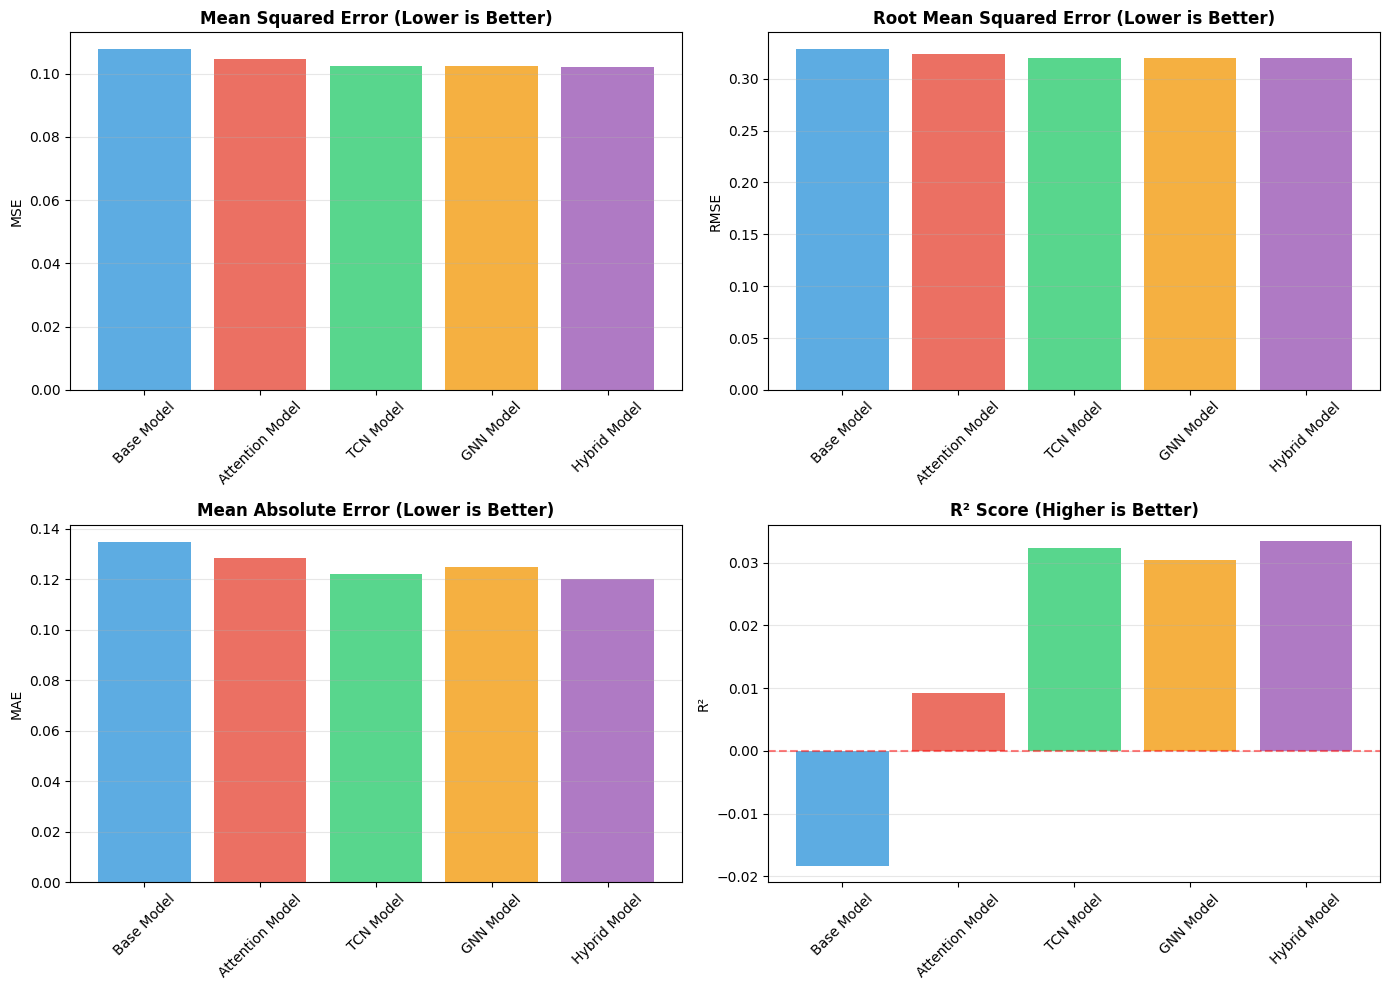

In [36]:
# Compare metrics across all models
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

model_names = list(all_metrics.keys())
colors = ['#3498DB', '#E74C3C', '#2ECC71', '#F39C12', '#9B59B6']

# MSE Comparison
mse_values = [all_metrics[m]['MSE'] for m in model_names]
axes[0, 0].bar(model_names, mse_values, color=colors, alpha=0.8)
axes[0, 0].set_title('Mean Squared Error (Lower is Better)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# RMSE Comparison
rmse_values = [all_metrics[m]['RMSE'] for m in model_names]
axes[0, 1].bar(model_names, rmse_values, color=colors, alpha=0.8)
axes[0, 1].set_title('Root Mean Squared Error (Lower is Better)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# MAE Comparison
mae_values = [all_metrics[m]['MAE'] for m in model_names]
axes[1, 0].bar(model_names, mae_values, color=colors, alpha=0.8)
axes[1, 0].set_title('Mean Absolute Error (Lower is Better)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# R² Comparison
r2_values = [all_metrics[m]['R2'] for m in model_names]
axes[1, 1].bar(model_names, r2_values, color=colors, alpha=0.8)
axes[1, 1].set_title('R² Score (Higher is Better)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('R²')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

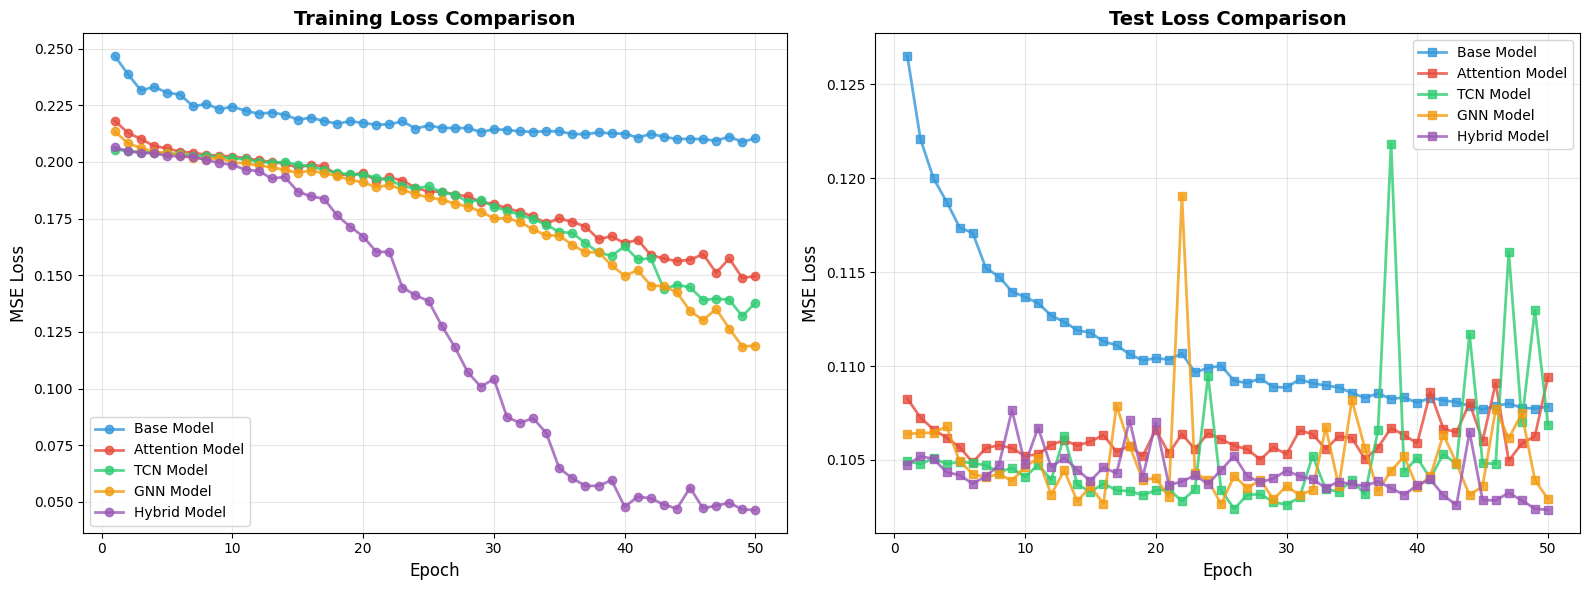

In [37]:
# Training curves comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Training losses
for model_name, color in zip(model_names, colors):
    epochs_range = range(1, len(results[model_name]['train_losses']) + 1)
    ax1.plot(epochs_range, results[model_name]['train_losses'], 
             marker='o', linestyle='-', color=color, linewidth=2, label=model_name, alpha=0.8)

ax1.set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('MSE Loss', fontsize=12)
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Test losses
for model_name, color in zip(model_names, colors):
    epochs_range = range(1, len(results[model_name]['test_losses']) + 1)
    ax2.plot(epochs_range, results[model_name]['test_losses'], 
             marker='s', linestyle='-', color=color, linewidth=2, label=model_name, alpha=0.8)

ax2.set_title('Test Loss Comparison', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('MSE Loss', fontsize=12)
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.3 Summary Table and Best Model Selection

In [39]:
# Create comprehensive summary table
import pandas as pd

summary_data = []
for model_name in model_names:
    summary_data.append({
        'Model': model_name,
        'Best Epoch': results[model_name]['best_epoch'],
        'Best Test Loss': results[model_name]['best_loss'],
        'MSE': all_metrics[model_name]['MSE'],
        'RMSE': all_metrics[model_name]['RMSE'],
        'MAE': all_metrics[model_name]['MAE'],
        'R² Score': all_metrics[model_name]['R2']
    })

summary_df = pd.DataFrame(summary_data)

print(f"\n{'='*80}")
print("COMPREHENSIVE MODEL COMPARISON SUMMARY")
print(f"{'='*80}\n")
print(summary_df.to_string(index=False))
print(f"\n{'='*80}\n")

# Find best model based on lowest test loss
best_model_idx = summary_df['Best Test Loss'].idxmin()
best_model_name = summary_df.loc[best_model_idx, 'Model']
improvement_pct = ((results['Base Model']['best_loss'] - results[best_model_name]['best_loss']) / 
                   results['Base Model']['best_loss'] * 100)

print(f"🏆 BEST MODEL: {best_model_name}")
print(f"   - Test Loss: {results[best_model_name]['best_loss']:.6f}")
print(f"   - Improvement over baseline: {improvement_pct:.2f}%")
print(f"   - R² Score: {all_metrics[best_model_name]['R2']:.6f}")
print(f"\n{'='*80}\n")


COMPREHENSIVE MODEL COMPARISON SUMMARY

          Model  Best Epoch  Best Test Loss      MSE     RMSE      MAE  R² Score
     Base Model          45        0.107692 0.107719 0.328206 0.134810 -0.018391
Attention Model           6        0.104870 0.104790 0.323713 0.128392  0.009302
      TCN Model          26        0.102392 0.102345 0.319914 0.122185  0.032418
      GNN Model          25        0.102643 0.102548 0.320231 0.124926  0.030502
   Hybrid Model          50        0.102332 0.102235 0.319742 0.120118  0.033463


🏆 BEST MODEL: Hybrid Model
   - Test Loss: 0.102332
   - Improvement over baseline: 4.98%
   - R² Score: 0.033463


